# DMI Types - Symbolically Generating the Finite Difference Form

In Fidimag, we have implemented the Dzyaloshinskii-Moriya interaction in such a way as to allow a user to specify any type of DMI they want.

Here we provide a symbolic algebra approach to the generation of such systems, which reduces the amount of tedious maths that one needs to do to use a new DMI type. All one needs to know is the combination of Lifshitz Invariants that make up the energy functional. This is trivial to extend to DMI types which have more than one DMI parameter.

It is worth noting that there is some discrepancy in the literature about the signs of the DMI parameter; it may be that to be consistent with the literature you must make the mapping $D$ to $-D$ for a particular energy class.

In [1]:
import numpy as np
import sympy as sp
from sympy.abc import x, y, z, i, j, k
from sympy import init_printing
import sympy.vector
from sympy.vector import Dot
init_printing()
N = sp.vector.CoordSys3D('N')

In [2]:
Mx, My, Mz = sp.symbols('M_x M_y M_z', cls=sp.Function)
D1, D2 = sp.symbols('D_1 D_2')
dl = sp.Symbol('\delta l')

def cross(a, b):
    return (a[1]*b[2] - a[2]*b[1],
            a[2]*b[0] - a[0]*b[2],
            a[0]*b[1] - a[1]*b[2])

def LI(i, j, k):
    """
    Symbolic representation of the Lifshitz Invariant
    
    $ L_{ij}^{(k)) $
    
    """
    Mi, Mj = sp.symbols(f'M_{str(i)} M_{str(j)}', cls=sp.Function)
    
    return Mi(x,y,z)*sp.diff(Mj(x, y, z), k) - Mj(x,y,z)*sp.diff(Mi(x,y,z), k)


def VarDeriv(w):
    Fx = sp.diff(w, Mx(x, y, z)) - sp.diff(sp.diff(w, sp.diff(Mx(x, y, z), x)), x) \
                                 - sp.diff(sp.diff(w, sp.diff(Mx(x, y, z), y)), y) \
                                 - sp.diff(sp.diff(w, sp.diff(Mx(x, y, z), z)), z)

    Fy = sp.diff(w, My(x, y, z)) - sp.diff(sp.diff(w, sp.diff(My(x, y, z), x)), x) \
                                 - sp.diff(sp.diff(w, sp.diff(My(x, y, z), y)), y) \
                                 - sp.diff(sp.diff(w, sp.diff(My(x, y, z), z)), z)

    Fz = sp.diff(w, Mz(x, y, z)) - sp.diff(sp.diff(w, sp.diff(Mz(x, y, z), x)), x) \
                                 - sp.diff(sp.diff(w, sp.diff(Mz(x, y, z), y)), y) \
                                 - sp.diff(sp.diff(w, sp.diff(Mz(x, y, z), z)), z)
    
    return sp.simplify(Fx)*N.x + sp.simplify(Fy)*N.y + sp.simplify(Fz)*N.z


def discretised_form(field):
    subs = {N.x:N.i, N.y:N.j, N.z:N.k}
    disc = sp.as_finite_diff(field, 2*dl).expand()
    xm =  sp.Add(*[argi for argi in disc.args if Mx(-dl + x, y, z) in argi.atoms(sp.Function)])
    xm += sp.Add(*[argi for argi in disc.args if My(-dl + x, y, z) in argi.atoms(sp.Function)])
    xm += sp.Add(*[argi for argi in disc.args if Mz(-dl + x, y, z) in argi.atoms(sp.Function)])
    xp =  sp.Add(*[argi for argi in disc.args if Mx(x + dl, y, z) in argi.atoms(sp.Function)])
    xp += sp.Add(*[argi for argi in disc.args if My(x + dl, y, z) in argi.atoms(sp.Function)])
    xp += sp.Add(*[argi for argi in disc.args if Mz(x + dl, y, z) in argi.atoms(sp.Function)])
    ym =  sp.Add(*[argi for argi in disc.args if Mx(x, y - dl, z) in argi.atoms(sp.Function)])
    ym += sp.Add(*[argi for argi in disc.args if My(x, y - dl, z) in argi.atoms(sp.Function)])
    ym += sp.Add(*[argi for argi in disc.args if Mz(x, y - dl, z) in argi.atoms(sp.Function)])
    yp =  sp.Add(*[argi for argi in disc.args if Mx(x, y + dl, z) in argi.atoms(sp.Function)])
    yp += sp.Add(*[argi for argi in disc.args if My(x, y + dl, z) in argi.atoms(sp.Function)])
    yp += sp.Add(*[argi for argi in disc.args if Mz(x, y + dl, z) in argi.atoms(sp.Function)])
    zm =  sp.Add(*[argi for argi in disc.args if Mx(x, y, z - dl) in argi.atoms(sp.Function)])
    zm += sp.Add(*[argi for argi in disc.args if My(x, y, z - dl) in argi.atoms(sp.Function)])
    zm += sp.Add(*[argi for argi in disc.args if Mz(x, y, z - dl) in argi.atoms(sp.Function)])
    zp =  sp.Add(*[argi for argi in disc.args if Mx(x, y, z + dl) in argi.atoms(sp.Function)])
    zp += sp.Add(*[argi for argi in disc.args if My(x, y, z + dl) in argi.atoms(sp.Function)])
    zp += sp.Add(*[argi for argi in disc.args if Mz(x, y, z + dl) in argi.atoms(sp.Function)])
    return xm.subs(subs), xp.subs(subs), ym.subs(subs), yp.subs(subs), zm.subs(subs), zp.subs(subs)

def discretised_form_to_vector_1D(dform):
    total_list = []

    for coord in dform:
        all_symbols = list(coord.free_symbols)
        if N.i not in all_symbols and \
           N.j not in all_symbols and \
           N.k not in all_symbols:
            total_list.append([0.0, 0, 0])
        
        elif N.i not in all_symbols:
            jterm = coord.coeff(N.k, 0)
            kterm = coord.coeff(N.j, 0)

            val = list(jterm.as_coefficients_dict().values())[0]
            if val == 1:
                total_list.append([1., 0, 0])
            else:
                total_list.append([-1., 0, 0])       
        elif N.j not in list(coord.free_symbols):
            iterm = coord.coeff(N.k, 0)
            kterm = coord.coeff(N.i, 0)

            val = list(iterm.as_coefficients_dict().values())[0]
            if val == -1:
                total_list.append([0., 1, 0])
            else:
                total_list.append([0., -1, 0])       
        else:
            iterm = coord.coeff(N.j, 0)
            jterm = coord.coeff(N.i, 0)
            val = list(iterm.as_coefficients_dict().values())[0]
            if val == 1:
                total_list.append([0., 0, 1])
            else:
                total_list.append([0., 0, -1])

    total_list = np.array(total_list).flatten()
    return total_list

def discretised_form_to_vector_2D(dform):
    total_list = []
    for D in [D1, D2]:
        for coord in dform:
            all_symbols = list(coord.coeff(D).free_symbols)
            if N.i not in all_symbols and \
               N.j not in all_symbols and \
               N.k not in all_symbols:
                total_list.append([0.0, 0, 0])

            elif N.i not in all_symbols:
                jterm = coord.coeff(N.k, 0)
                kterm = coord.coeff(N.j, 0)

                val = list(jterm.as_coefficients_dict().values())[0]
                if val == 1:
                    total_list.append([1., 0, 0])
                else:
                    total_list.append([-1., 0, 0])       
            elif N.j not in list(coord.free_symbols):
                iterm = coord.coeff(N.k, 0)
                kterm = coord.coeff(N.i, 0)

                val = list(iterm.as_coefficients_dict().values())[0]
                if val == -1:
                    total_list.append([0., 1, 0])
                else:
                    total_list.append([0., -1, 0])       
            else:
                iterm = coord.coeff(N.j, 0)
                jterm = coord.coeff(N.i, 0)
                val = list(iterm.as_coefficients_dict().values())[0]
                if val == 1:
                    total_list.append([0., 0, 1])
                else:
                    total_list.append([0., 0, -1])

    total_list = np.array(total_list).flatten()
    return total_list
    

# Crystal Class T

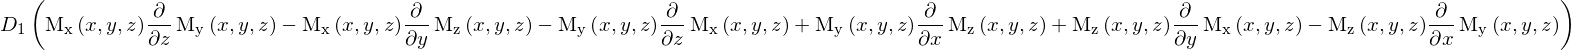

In [3]:
T = D1 * (LI(x, y, z) + LI(y, z, x) + LI(z, x, y))
T

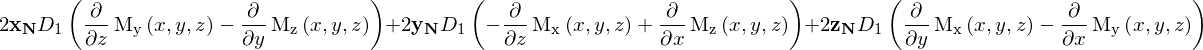

In [4]:
F_T = VarDeriv(T)
F_T

In [5]:
xm, xp, ym, yp, zm, zp = discretised_form(F_T)
dform = xm , xp, ym, yp, zm, zp

/usr/local/lib/python3.7/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


In [6]:
discretised_form_to_vector_1D(dform)

array([-1.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,
        0., -1.,  0.,  0.,  1.])

# Crystal Class C_nv

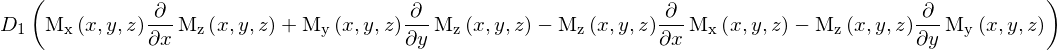

In [7]:
C_nv = D1 * (LI(x, z, x) + LI(y, z, y))
C_nv

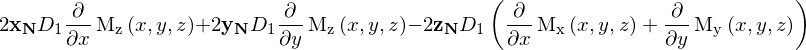

In [8]:
F_C_nv = VarDeriv(C_nv)
F_C_nv

/usr/local/lib/python3.7/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


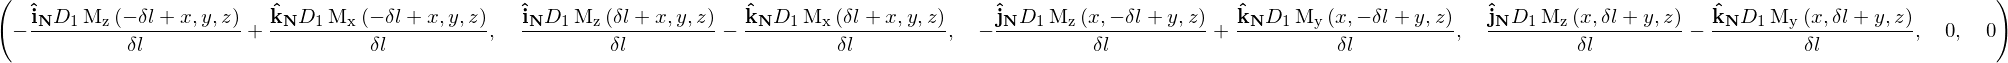

In [9]:
dform_C_nv = discretised_form(F_C_nv)
dform_C_nv

In [10]:
discretised_form_to_vector_1D(dform_C_nv)

array([ 0.,  1.,  0.,  0., -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

# Crystal Class D_2d

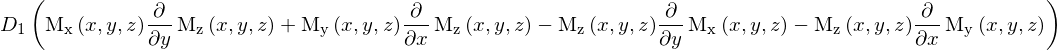

In [11]:
D_2d = D1 * (LI(y, z, x) + LI(x, z, y))
D_2d

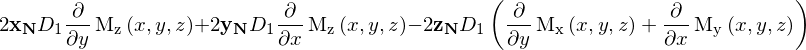

In [12]:
F_D_2d = VarDeriv(D_2d)
F_D_2d

/usr/local/lib/python3.7/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


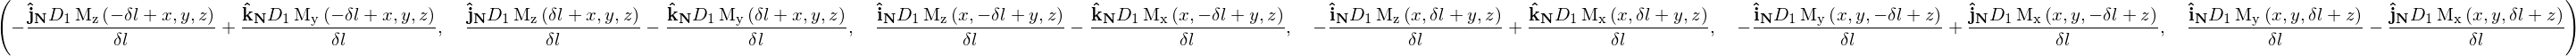

In [13]:
dform_D_2d = discretised_form(F_D_2d)
dform

In [14]:
discretised_form_to_vector_1D(dform_D_2d)

array([-1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

# D_n

See here for details:

https://arxiv.org/pdf/1406.2177.pdf


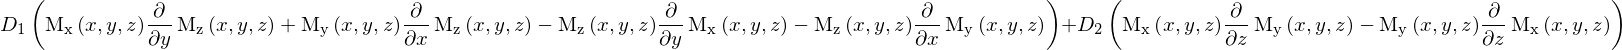

In [15]:
D_n = D1 * (LI(x, z, y) + LI(y, z, x)) + D2*LI(x, y, z)
D_n

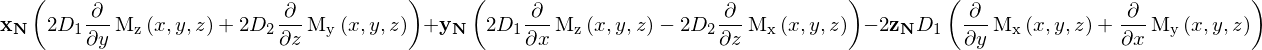

In [16]:
F_D_n = VarDeriv(D_n)
F_D_n

/usr/local/lib/python3.7/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


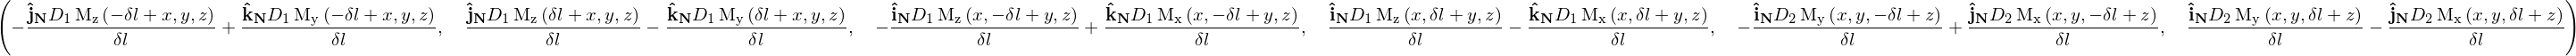

In [17]:
dform_D_n = discretised_form(F_D_n)
dform_D_n

In [18]:
discretised_form_to_vector_2D(dform_D_n)

array([-1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.])

# C_n

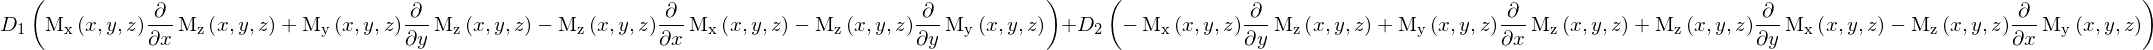

In [19]:
C_n = D1 * (LI(y, z, y) + LI(x, z, x)) + D2 * (LI(y, z, x) - LI(x, z, y))
C_n

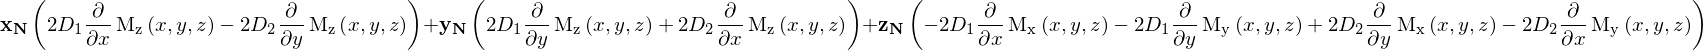

In [20]:
F_C_n = VarDeriv(C_n)
F_C_n

In [21]:
dform_C_n = discretised_form(F_C_n)
discretised_form_to_vector_2D(dform_C_n)

/usr/local/lib/python3.7/site-packages/sympy/core/decorators.py:38: SymPyDeprecationWarning: 

_as_finite_diff has been deprecated since SymPy 1.1. Use
Derivative.as_finite_difference instead. See
https://github.com/sympy/sympy/issues/11410 for more info.

  _warn_deprecation(wrapped, 3)


array([ 0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])